# IMPORT LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score
from sklearn.decomposition import PCA

import seaborn as sns

import matplotlib.pyplot as plt

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

## Cryptocurrency List

In [2]:
dfCrpytocurrencies = pd.read_excel('Static Data\crpytocurrencies.xlsx')
dfCrpytocurrencies.head()

,Symbol
0,BTCUSD
1,ETHUSD
2,BCHUSD
3,LTCUSD
4,RPLUSD


## MetaTrader 5

In [3]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 9, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2022, 3, 10, tzinfo=gc_o_TIME_ZONE)

In [4]:
def aFetchFromMT5(sSymbol,dtFrom, dtTo, oFreq):
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    aOhlcSample = mt5.copy_rates_range(
        sSymbol,
        oFreq,
        dtFrom, 
        dtTo
    )

    if len(aOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()
    return aOhlcSample

In [5]:
sOutputSymbol = "BTCUSD"
aInputSymbols = dfCrpytocurrencies['Symbol'].values

aSymbolsToFetch = np.append(aInputSymbols, sOutputSymbol)
aSymbolsToFetch = np.unique(aSymbolsToFetch)

In [6]:
dfOhlcSource = pd.read_csv('dfOhlcSource.csv')
dfOhlcSource['timestamp'] = pd.DatetimeIndex(dfOhlcSource['timestamp'])
dfOhlcSource.set_index('timestamp', inplace=True)

# PREPROCESSING

In [7]:
sModelName = os.path.join(sOutputSymbol , "__deep learning model__")

## Add Seasonal Features

In [8]:
dfOhlcSource["weekday"] = dfOhlcSource.index.weekday
dfOhlcSource["hour"] = dfOhlcSource.index.hour
dfOhlcSource["minute"] = dfOhlcSource.index.minute

## Add Return Feature

In [9]:
dfOhlcSource["return"] = (dfOhlcSource["close"] - dfOhlcSource["open"])/dfOhlcSource["open"]

## Add Candle Features

In [10]:
dfOhlcSource["upper_shadow"] =( dfOhlcSource["high"] - dfOhlcSource[['close', 'open']].max(axis=1))/ dfOhlcSource[['close', 'open']].max(axis=1)
dfOhlcSource["lower_shadow"] = (dfOhlcSource[['close', 'open']].min(axis=1) - dfOhlcSource["low"])/dfOhlcSource["low"]

## Transform Symbols to Columns

In [11]:
dfOhlc = pd.DataFrame()

i = 1
for sSymbol in aSymbolsToFetch:
    dfSymbolValues = dfOhlcSource[dfOhlcSource['symbol'] == sSymbol]

    if i == 1:
        sHow = "right"
    else:
        sHow = "inner"
    
    dfSymbolValues = dfSymbolValues.drop('symbol', axis = 1)
    
    dfOhlc = dfOhlc.join(dfSymbolValues,how = sHow, rsuffix=sSymbol)
    
    i = i + 1
    
aColumnsOhlc = list()
for sSymbol in aSymbolsToFetch:
    for sColumn in dfOhlcSource.columns:
        if sColumn != 'symbol':
            sNewColumn = sSymbol + ";" + sColumn
            aColumnsOhlc.append(sNewColumn)
    
dfOhlc.columns = aColumnsOhlc

dfOhlc.head()

,BCHUSD;open,BCHUSD;high,BCHUSD;low,BCHUSD;close,BCHUSD;tick_volume,BCHUSD;spread,BCHUSD;real_volume,BCHUSD;weekday,BCHUSD;hour,BCHUSD;minute,...,RPLUSD;tick_volume,RPLUSD;spread,RPLUSD;real_volume,RPLUSD;weekday,RPLUSD;hour,RPLUSD;minute,RPLUSD;return,RPLUSD;upper_shadow,RPLUSD;lower_shadow,RPLUSD;body
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,618.16,633.29,618.16,630.75,768,405,0,2,0,0,...,597,30,0,2,0,0,0.005549,0.006028,0.001453,0.0065
2021-09-01 00:30:00,630.74,634.04,629.43,629.66,899,405,0,2,0,30,...,1356,36,0,2,0,30,-0.000509,0.010527,0.001446,0.0006
2021-09-01 01:00:00,629.62,631.06,626.84,628.04,1252,405,0,2,1,0,...,1434,31,0,2,1,0,-0.017413,0.002633,0.008544,0.0205
2021-09-01 01:30:00,628.04,632.47,626.38,632.33,1446,405,0,2,1,30,...,1365,30,0,2,1,30,0.012621,0.001451,0.004254,0.0146
2021-09-01 02:00:00,632.38,634.64,630.44,634.34,1542,405,0,2,2,0,...,1422,30,0,2,2,0,0.004183,0.002890,0.007829,0.0049


## Split Data

In [12]:
fTrainingRatio = 0.7
fValidationRatio = 0.15
fTestRatio = 0.15

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest = train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

In [13]:
# sns.lineplot(data = dfScaledOhlc.loc[ixTrain, sOutputSymbol + ';return'], color = 'green', legend = True)
# sns.lineplot(data = dfScaledOhlc.loc[ixValidation,sOutputSymbol + ';return'], color = 'yellow', legend = True)
# sns.lineplot(data = dfScaledOhlc.loc[ixTest, sOutputSymbol + ';return'], color = 'red', legend = True)

In [14]:
# sns.histplot(data = dfScaledOhlc.loc[ixTrain,sOutputSymbol + ';return'], color = 'green', legend = True)
# sns.histplot(data = dfScaledOhlc.loc[ixValidation, sOutputSymbol + ';return'], color = 'yellow', legend = True)
# sns.histplot(data = dfScaledOhlc.loc[ixTest,sOutputSymbol + ';return'], color = 'red', legend = True)

## Scale Data

In [15]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)

for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain.append(dfValidation))
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Input Dataset

In [16]:
aInputFeatures = ['weekday', 'hour', 'minute' ,'upper_shadow', 'lower_shadow' ,'return']
aInputFeatures = list(map(";".join, itertools.product(aInputSymbols, aInputFeatures)))

iNrInputFeatures = len(aInputFeatures)

iBackwardTimeWindow = 8
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

aTplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
aIxInputColumns = pd.MultiIndex.from_tuples(aTplInputColumns, names= ['time_step', 'feature'])

dfInput = pd.DataFrame(columns = aIxInputColumns)

for tplColumn in list(dfInput.columns):
    dfInput.loc[:, tplColumn] = dfScaledOhlc[(tplColumn[1])].shift(-tplColumn[0])

    
ixNas = dfInput[dfInput.isna().any(axis=1)].index
dfInput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 

dfInput.head()

time_step                       -8                            \
feature             BTCUSD;weekday BTCUSD;hour BTCUSD;minute   
timestamp                                                      
2021-09-01 04:00:00      -0.003076   -1.662613          -1.0   
2021-09-01 04:30:00      -0.003076   -1.662613           1.0   
2021-09-01 05:00:00      -0.003076   -1.517929          -1.0   
2021-09-01 05:30:00      -0.003076   -1.517929           1.0   
2021-09-01 06:00:00      -0.003076   -1.373245          -1.0   

time_step                                                                  \
feature             BTCUSD;upper_shadow BTCUSD;lower_shadow BTCUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            0.272382           -0.344248      0.367626   
2021-09-01 04:30:00            1.482079           -0.838114     -0.274886   
2021-09-01 05:00:00             0.09279           -0.050609     -0.230078   
2021-09-01 05:30:00           -0.792066           -0.003061      0.948749   
2021-09-01 06:00:00           -0.402557           -0.069069      0.438649   

time_step                                                     \
feature             ETHUSD;weekday ETHUSD;hour ETHUSD;minute   
timestamp                                                      
2021-09-01 04:00:00      -0.003076   -1.662613          -1.0   
2021-09-01 04:30:00      -0.003076   -1.662613           1.0   
2021-09-01 05:00:00      -0.003076   -1.517929          -1.0   
2021-09-01 05:30:00      -0.003076   -1.517929           1.0   
2021-09-01 06:00:00      -0.003076   -1.373245          -1.0   

time_step                                ...            -1  \
feature             ETHUSD;upper_shadow  ... LTCUSD;minute   
timestamp                                ...                 
2021-09-01 04:00:00            0.101196  ...           1.0   
2021-09-01 04:30:00            2.108089  ...          -1.0   
2021-09-01 05:00:00              0.5739  ...           1.0   
2021-09-01 05:30:00           -0.693713  ...          -1.0   
2021-09-01 06:00:00           -0.541873  ...           1.0   

time_step                                                                  \
feature             LTCUSD;upper_shadow LTCUSD;lower_shadow LTCUSD;return   
timestamp                                                                   
2021-09-01 04:00:00            -0.84953           -0.301025      -0.95781   
2021-09-01 04:30:00           -0.597665            0.115612      0.283424   
2021-09-01 05:00:00            0.283195            0.252142      0.787553   
2021-09-01 05:30:00           -0.565569            0.300058      1.185322   
2021-09-01 06:00:00           -0.413653           -0.019622       -0.7982   

time_step                                                     \
feature             RPLUSD;weekday RPLUSD;hour RPLUSD;minute   
timestamp                                                      
2021-09-01 04:00:00      -0.003076   -1.228561           1.0   
2021-09-01 04:30:00      -0.003076   -1.083877          -1.0   
2021-09-01 05:00:00      -0.003076   -1.083877           1.0   
2021-09-01 05:30:00      -0.003076   -0.939193          -1.0   
2021-09-01 06:00:00      -0.003076   -0.939193           1.0   

time_step                                                                  
feature             RPLUSD;upper_shadow RPLUSD;lower_shadow RPLUSD;return  
timestamp                                                                  
2021-09-01 04:00:00           -0.825667           -0.338218     -2.538037  
2021-09-01 04:30:00            -0.51259             0.08902      0.969554  
2021-09-01 05:00:00            0.169086            0.772446      0.542918  
2021-09-01 05:30:00           -0.607891            0.725477      0.177932  
2021-09-01 06:00:00            1.253305            0.364063     -0.469939  

[5 rows x 240 columns]

## Output Dataset

In [17]:
aOutputFeatures = ['return']
aOutputFeatures = list(map(";".join, itertools.product([sOutputSymbol], aOutputFeatures)))
iNrOutputFeatures = len(aOutputFeatures)

iForwardTimeWindow = 4
aForwardTimeSteps = range(0, iForwardTimeWindow)


aTplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
aIxOutputColumns = pd.MultiIndex.from_tuples(aTplOutputColumns, names= ['time_step', 'feature'])

dfOutput = pd.DataFrame(columns = aIxOutputColumns)

for tplColumn in list(dfOutput.columns):
    dfOutput.loc[:, tplColumn] =  dfOhlc[(tplColumn[1])].shift(-tplColumn[0])

ixNas = dfOutput[dfOutput.isna().any(axis=1)].index
dfOutput.drop(ixNas, inplace = True, errors = 'ignore') 
ixTrain= ixTrain.drop(ixNas, errors = 'ignore') 
ixValidation= ixValidation.drop(ixNas,   errors = 'ignore') 
ixTest = ixTest.drop(ixNas,   errors = 'ignore') 
dfOutput.head()

time_step,0,1,2,3
feature,BTCUSD;return,BTCUSD;return,BTCUSD;return,BTCUSD;return
timestamp,,,,
2021-09-01 00:00:00,0.001941,-0.001465,-0.001227,0.005021
2021-09-01 00:30:00,-0.001465,-0.001227,0.005021,0.002318
2021-09-01 01:00:00,-0.001227,0.005021,0.002318,-0.002022
2021-09-01 01:30:00,0.005021,0.002318,-0.002022,-0.001229
2021-09-01 02:00:00,0.002318,-0.002022,-0.001229,-0.006108


## Reshape Datasets

In [18]:
axMerged = dfInput.index.join(dfOutput.index, how = 'inner')

dfInput = dfInput.loc[axMerged]
dfOutput = dfOutput.loc[axMerged]

ixTrain = ixTrain.join(axMerged, how = "inner")
ixValidation = ixValidation.join(axMerged, how = "inner")
ixTest = ixTest.join(axMerged, how = "inner")

In [19]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [20]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

#  MODEL DEVELOPMENT

## Set Hyperparameters

In [21]:
iBatchSize = 64
iEpochSize = 10000
iNrOfHiddenNeurons = 32

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

## Define Loss Function

In [22]:
def fCalculateLoss(aActual, aPrediction):
    aErrors = tf.abs(
        tf.subtract(aActual, aPrediction) 
    ) #(row: iBatchSize, col: iForwardTimeWindow-1)

    fBiggestError = tf.math.reduce_max(aErrors)
    
    aLossesDueToErrors = tf.reduce_sum(aErrors, 0) #(row: 1, col: iForwardTimeWindow)
    
    
    aDeltaSignsOfReturns = tf.abs(
        tf.sign(aActual) - tf.sign(aPrediction)
    ) # will be between [0 : no sign diff, 2: diff signs]  (row: iBatchSize, col: iForwardTimeWindow)
    
    aLossesDueToSignsOfReturns = tf.math.reduce_sum(aDeltaSignsOfReturns, 0) #(row: 1, col: iForwardTimeWindow)
    aTotalLosses = aLossesDueToErrors * aLossesDueToSignsOfReturns * fBiggestError
    
    fLoss = tf.math.reduce_mean(aTotalLosses)
    
    return fLoss

## Build Model

### Deep MLP

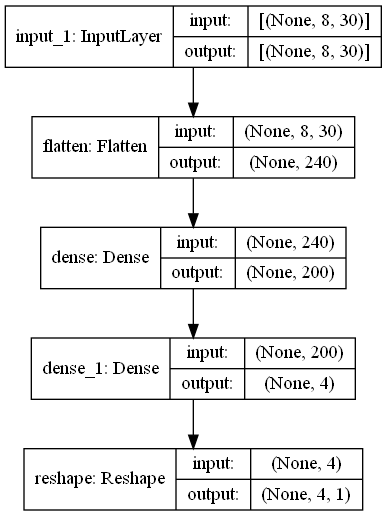

In [23]:
aInputDeepMlp = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures))

aW = keras.layers.Flatten()(aInputDeepMlp)
aW = keras.layers.Dense(200)(aW)
aW = keras.layers.Dense(iForwardTimeWindow*iNrOutputFeatures)(aW)
aW = keras.layers.Reshape((iForwardTimeWindow, iNrOutputFeatures))(aW)

aOutputDeepMlp = aW
oModelDeepMlp = keras.Model(
    inputs=aInputDeepMlp,
    outputs=aOutputDeepMlp
)

oOptimizerDeepMlp = tf.keras.optimizers.Adam(learning_rate=1e-04)
oModelDeepMlp.compile(optimizer=oOptimizerDeepMlp,
                         loss = fCalculateLoss
                        )

oPredictiveModel = oModelDeepMlp

tf.keras.utils.plot_model(oModelDeepMlp,  show_shapes=True)

### LSTM

### Deep CNN

In [24]:
# aInputDeepCnn = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.LSTM(64, return_sequences = True)(aInputDeepCnn)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures * iNrOfBins, iForwardTimeWindow, 1))(aW)
# aW = keras.layers.Conv2D(64, (4,4), (1,1), padding = "same" )(aW)
# aW = keras.layers.MaxPool2D(pool_size = (4, 4))(aW)
# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOfBins*iForwardTimeWindow*iNrOutputFeatures)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputDeepCnn = aW
# oModelDeepCnn = keras.Model(
#     inputs=aInputDeepCnn,
#     outputs=aOutputDeepCnn
# )

# oOptimizerDeepCnn = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDeepCnn.compile(optimizer=oOptimizerDeepCnn,
#                          loss = fCalculateLoss
#                         )

# tf.keras.utils.plot_model(oModelDeepCnn,  show_shapes=True)

#### Deep Convolutional Generative Adversarial Network Model

##### Generator Model

In [25]:
# aInputGenerator = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))

# aW = keras.layers.Flatten()(aInputGenerator)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Reshape((iNrOutputFeatures*iNrOfBins, iForwardTimeWindow, 1))(aW)

# aW = keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(aW)
# aW = keras.layers.BatchNormalization()(aW)
# aW = keras.layers.LeakyReLU()(aW)

# aW = keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(iNrOutputFeatures*iNrOfBins*iForwardTimeWindow, use_bias=False)(aW)
# aW = keras.layers.Reshape((iNrOutputFeatures, iNrOfBins, iForwardTimeWindow))(aW)

# aOutputGenerator = aW
# oModelGenerator = keras.Model(inputs = aInputGenerator, 
#                               outputs = aOutputGenerator)

# def fCalculateGeneratorLoss(aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fTotalLoss = oCrossEntropy(tf.ones_like(aFakeOutput), aFakeOutput)
#     return fTotalLoss

# oOptimizerGenerator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelGenerator.compile(optimizer=oOptimizerGenerator,
#                          loss = fCalculateGeneratorLoss
#                         )

# tf.keras.utils.plot_model(oModelGenerator,  show_shapes=True)

##### Discriminator Model

In [26]:
# aInputDiscrimantor= keras.Input(
#     shape=(iNrOutputFeatures, iNrOfBins, iForwardTimeWindow),
#     name = "aInputDiscrimantor")


# aW = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(aInputDiscrimantor)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(aW)
# aW = keras.layers.LeakyReLU()(aW)
# aW = keras.layers.Dropout(0.3)(aW)

# aW = keras.layers.Flatten()(aW)
# aW = keras.layers.Dense(1)(aW)

# def fCalculateDiscrimantorLoss(aRealOutput, aFakeOutput):
#     oCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#     fRealLoss = oCrossEntropy(tf.ones_like(aRealOutput), aRealOutput)
#     fFakeLoss = oCrossEntropy(tf.zeros_like(aFakeOutput), aFakeOutput)
#     fTotalLoss = fRealLoss + fFakeLoss
#     return fTotalLoss

# aOutputDiscriminator = aW
# oModelDiscriminator = keras.Model(
#     inputs=aInputDiscrimantor,
#     outputs=aOutputDiscriminator
# )

# oOptimizerDiscriminator = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oModelDiscriminator.compile(optimizer=oOptimizerDiscriminator,
#                          loss = fCalculateDiscrimantorLoss
#                            )

# tf.keras.utils.plot_model(oModelDiscriminator,  show_shapes=True)

##### GAN Model

In [27]:
# @tf.function
# def trainStep(aOutputActual):
#     aNoiseInput = tf.random.normal([iBatchSize, iBackwardTimeWindow, iNrInputFeatures])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         aOutputGenerated = oModelGenerator(aNoiseInput, training=True)
#         aFake = oModelDiscriminator(aOutputGenerated, training=True)
        
#         aReal = oModelDiscriminator(aOutputActual, training=True)
        
#         fLossGenerator = fCalculateGeneratorLoss(aFake)
#         fLossDiscriminator = fCalculateDiscrimantorLoss(aReal, aFake)

#     aGradientsGenerator = gen_tape.gradient(fLossGenerator, oModelGenerator.trainable_variables)
#     aGradientsDiscriminator = disc_tape.gradient(fLossDiscriminator, oModelDiscriminator.trainable_variables)

#     oOptimizerGenerator.apply_gradients(zip(aGradientsGenerator, oModelGenerator.trainable_variables))
#     oOptimizerDiscriminator.apply_gradients(zip(aGradientsDiscriminator, oModelDiscriminator.trainable_variables))
    
    

# for iEpoch in range(iEpochSize):
#     dtStart = time.time()

#     dsOutputTrain = tf.data.Dataset.from_tensor_slices(aPixelOutputTrain).batch(iBatchSize)
#     for aOutputTrain in dsOutputTrain:
#         trainStep(aOutputTrain)

#     print ('Time for epoch {} is {} sec'.format(iEpoch + 1, time.time()-dtStart))

### Convolutional Encoder-Decoder Model

### Luong's Attention Model

In [28]:
# aEncoderInputs = keras.Input(
#     shape=(iBackwardTimeWindow, iNrInputFeatures))


# aEncoderHiddens, aFinalH, aFinalC = keras.layers.LSTM(iNrOfHiddenNeurons,
#                                          return_state = True, 
#                                          return_sequences = True
#                                         )(aEncoderInputs)
# aFinalH = keras.layers.BatchNormalization()(aFinalH)
# aFinalC = keras.layers.BatchNormalization()(aFinalC)

# aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFinalH)

# aDecoderHiddens = keras.layers.LSTM(iNrOfHiddenNeurons, 
#                        return_state = False, 
#                        return_sequences = True
#                       )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

# aAttentions = keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
# aAttentions = keras.layers.Activation('softmax')(aAttentions)

# aContextVector = keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
# aContextVector = keras.layers.BatchNormalization()(aContextVector)
# aContextVector = keras.layers.concatenate([aContextVector, aDecoderHiddens])

# aDecoderOutputs = keras.layers.TimeDistributed(
#     Dense(iNrOutputFeatures)
# )(aContextVector)

# oPredictiveModel = keras.Model(
#     inputs=aEncoderInputs,
#     outputs=aDecoderOutputs
# )

# oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
# oPredictiveModel.compile(loss = fCalculateLoss, 
#                          optimizer=oOptimizer
#                         )

# tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True)

## Fit Model

In [29]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize
    ,callbacks=[oEarlyStop]
)

Epoch 1/10000
72/72 [==============================] - 1s 5ms/step - loss: 14349.8633 - val_loss: 5875.6440
Epoch 2/10000
72/72 [==============================] - 0s 4ms/step - loss: 7199.2100 - val_loss: 3872.5815
Epoch 3/10000
72/72 [==============================] - 0s 4ms/step - loss: 4844.3677 - val_loss: 2758.6316
Epoch 4/10000
72/72 [==============================] - 0s 3ms/step - loss: 3546.0366 - val_loss: 2211.4692
Epoch 5/10000
72/72 [==============================] - 0s 2ms/step - loss: 2968.6538 - val_loss: 1879.1947
Epoch 6/10000
72/72 [==============================] - 0s 2ms/step - loss: 2545.6812 - val_loss: 1498.7042
Epoch 7/10000
72/72 [==============================] - 0s 2ms/step - loss: 2221.5874 - val_loss: 1330.1213
Epoch 8/10000
72/72 [==============================] - 0s 2ms/step - loss: 1948.8381 - val_loss: 1247.2296
Epoch 9/10000
72/72 [==============================] - 0s 2ms/step - loss: 1657.3562 - val_loss: 1085.1195
Epoch 10/10000
72/72 [==============

### Save Model

In [30]:
oPredictiveModel.save_weights(sModelName)

<AxesSubplot:>

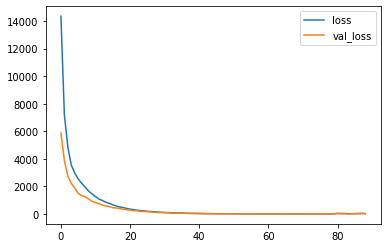

In [31]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test Model

In [32]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(data = aPrediction, index = ixTest, columns = aIxOutputColumns)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(data = aActual, index = ixTest, columns = aIxOutputColumns).copy()

# RESULTS

In [58]:
def dfGetClosePricesFromReturns(dfToConvert):
    dfClose = dfToConvert.copy() 
    dfClose.rename(columns = {'BTCUSD;return':'BTCUSD;close'}, level=1)

    for sCol in dfClose.columns:
        iTimeStep = sCol[0]
        sSymbolFeature = sCol[1]
        aSymbolFeature = sSymbolFeature.split(';')
        sSymbol = aSymbolFeature[0]
        sFeature = aSymbolFeature[1]
        
        dfReturns = dfToConvert.loc[:,sCol ]

        if iTimeStep == 0:
            dfOpenPrices = dfOhlc.loc[dfClose.index, sSymbol+';open']
        else:
            dfOpenPrices =  dfClose.loc[:, (iTimeStep-1, sSymbolFeature)]
        
        dfClose.loc[:, sCol] = (dfOpenPrices * dfReturns) + dfOpenPrices
        
    return dfClose

In [59]:
dfActualClose = dfGetClosePricesFromReturns(dfActual)
dfPredictionClose = dfGetClosePricesFromReturns(dfPrediction)

In [60]:
iComparisionTimeStep = 3

In [61]:
y_pred = dfPredictionClose.iloc[:, iComparisionTimeStep]
y_true = dfActualClose.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:              537.920
       mean squared error:           494453.877
                max error:             4139.571
                 r2 score:                0.931


<AxesSubplot:xlabel='Actual', ylabel='Prediction'>

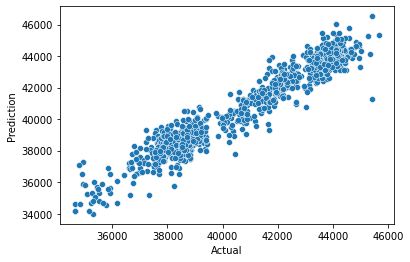

In [62]:
dfTestComparision = pd.DataFrame(dfPredictionClose.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActualClose.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

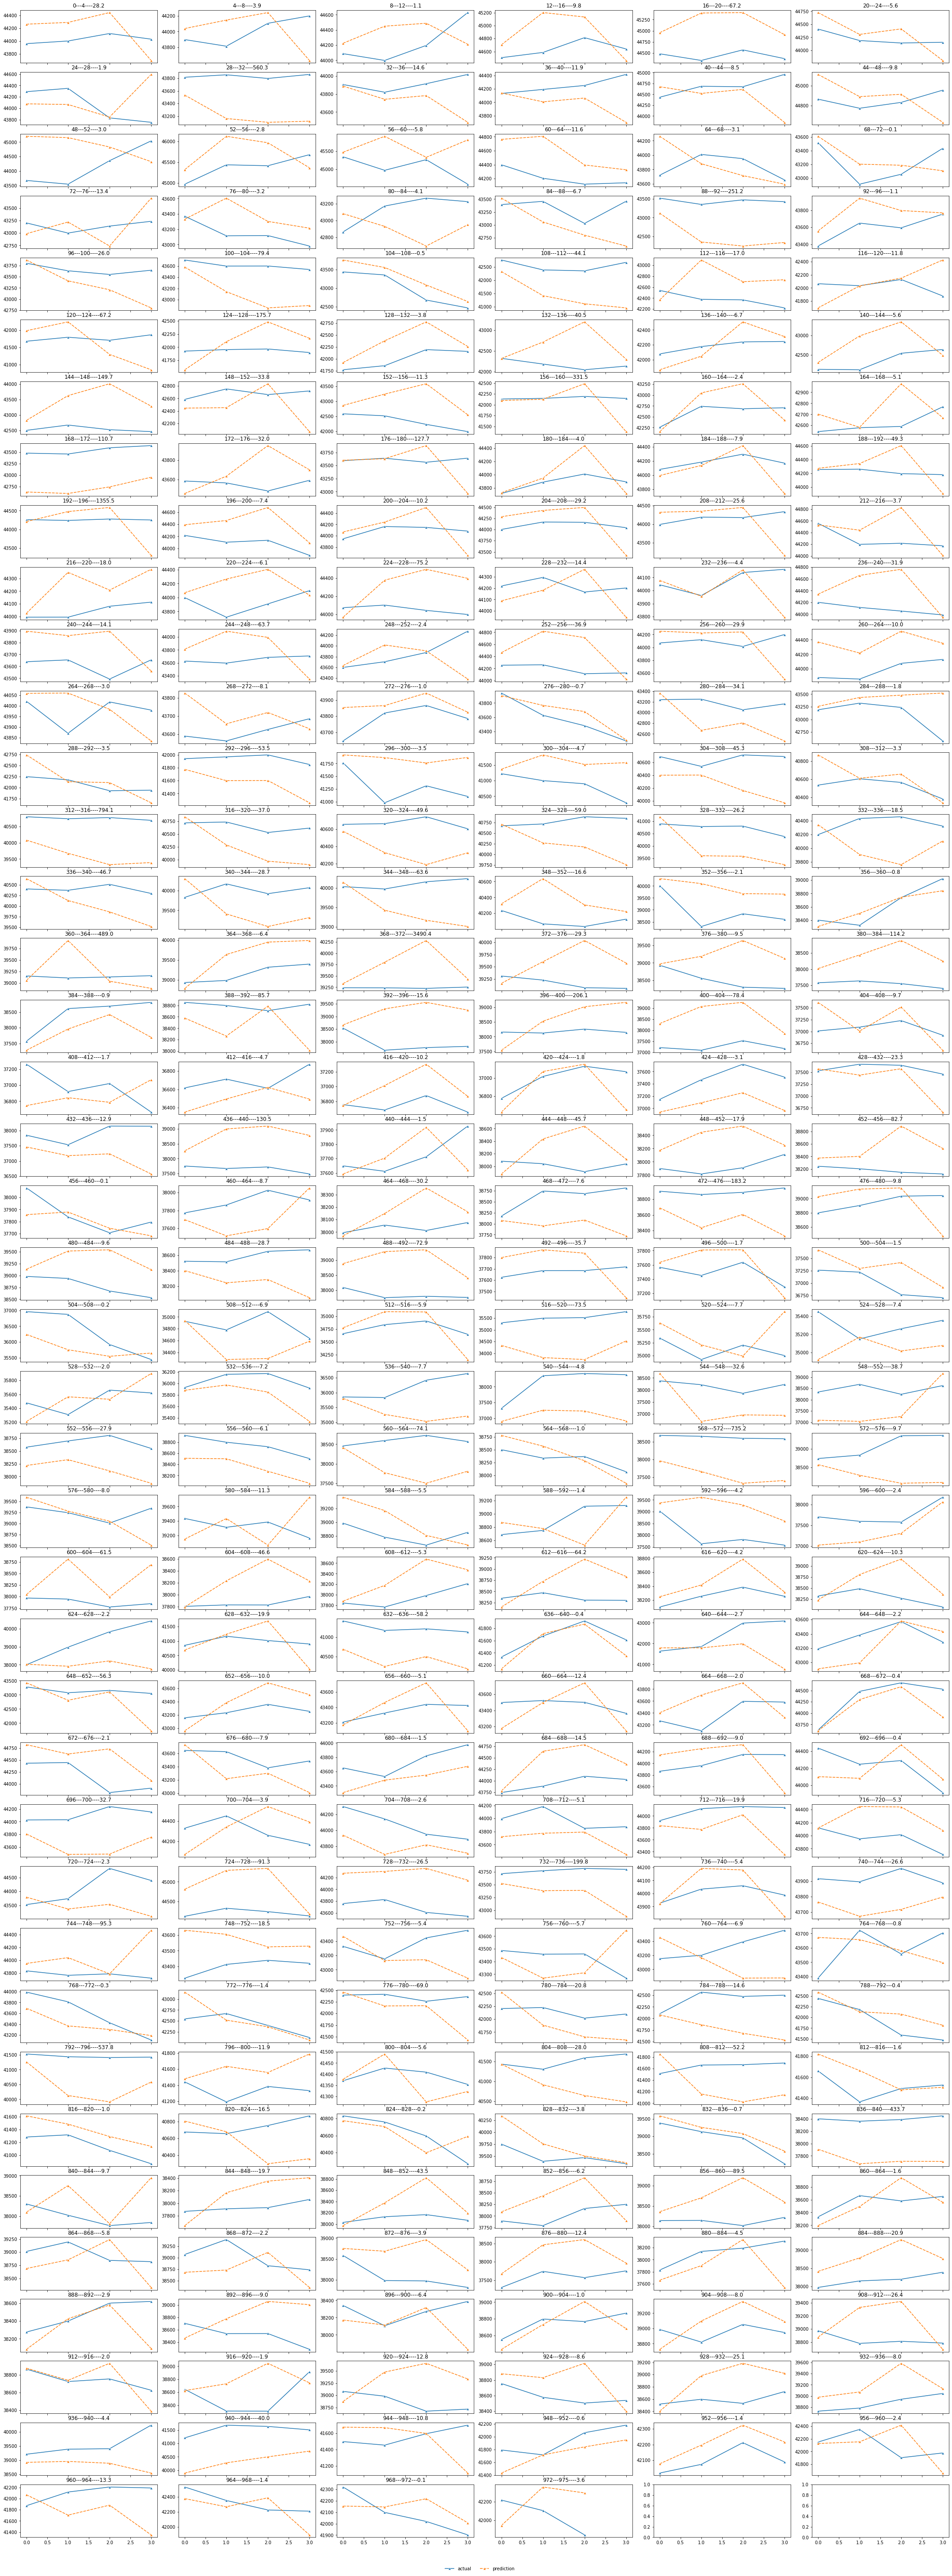

In [63]:
iNrOfCols = 6
iNrOfRows = int(((len(dfActualClose)/iNrOfCols)/iForwardTimeWindow) + 1)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(30,80), sharex = True)
oFig.tight_layout()
i = 0
for iSampleNr in range(0, len(dfActualClose), iForwardTimeWindow):
    iFrom = iSampleNr
    iTo = iFrom + iForwardTimeWindow

    if iTo >= len(dfActualClose):
        iTo = len(dfActualClose) 
    
    dfStepComparision = dfActualClose.iloc[iFrom:iTo].loc[:, (slice(None), slice(aOutputFeatures[0]))].loc[:, 0]
    dfStepComparision.columns = ["Actual"]

    dfStepComparision["Prediction"] = dfPredictionClose.iloc[iFrom].iloc[0:iTo-iFrom].loc[:, aOutputFeatures].values
    
    
    sTitleName = str(iFrom) + "---" + str(iTo) + "---" + str(round(r2_score(dfStepComparision["Actual"], dfStepComparision["Prediction"]),1))
    
    iSampleGraphRow =  int(i/iNrOfCols)
    iSampleGraphCol = int(i%iNrOfCols)
    
    dfStepComparision.reset_index(inplace = True)
    sns.lineplot(ax =aAxises[iSampleGraphRow,iSampleGraphCol] , data = dfStepComparision, legend = False,  marker = '^').set_title(sTitleName)
    
    i = i + 1

oFig.legend(aAxises[0][0].lines, ['actual', 'prediction'], frameon=False, loc='lower center', ncol=2,  bbox_to_anchor=(0.5,-0.01))  

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb